In [17]:
!pip install pytorch_forecasting

     |████████████████████████████████| 112 kB 5.1 MB/s eta 0:00:01


In [18]:
import warnings
import numpy as np
import pandas as pd
import copy
from pathlib import Path
import torch
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import pytorch_forecasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [19]:
df_train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv' ,parse_dates=['date'])
df_shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
df_items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
df_item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')


In [20]:
df_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [21]:
df_train['date'] = pd.to_datetime(df_train['date'], errors='corece')

In [22]:
# change the item count per day to item count per month by using group
df_train = df_train.groupby(["item_id","shop_id","date_block_num"]).sum().reset_index()
df_train = df_train.rename(index=str, columns = {"item_cnt_day" : "item_cnt_month"})
df_train = df_train[["item_id","shop_id","date_block_num","item_cnt_month"]]
df_train

,item_id,shop_id,date_block_num,item_cnt_month
0,0,54,20,1.0
1,1,55,15,2.0
2,1,55,18,1.0
3,1,55,19,1.0
4,1,55,20,1.0
...,...,...,...,...
1609119,22168,12,8,1.0
1609120,22168,16,1,1.0
1609121,22168,42,1,1.0
1609122,22168,43,2,1.0


In [13]:
df_train['date_block_num'].describe()

count    1.609124e+06
mean     1.466479e+01
std      9.542322e+00
min      0.000000e+00
25%      6.000000e+00
50%      1.400000e+01
75%      2.300000e+01
max      3.300000e+01
Name: date_block_num, dtype: float64

In [24]:
# Create The Time Series Dataset
max_prediction_length = 1
max_encoder_length = 27
training_cutoff = df_train['date_block_num'].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_train[lambda x: x['date_block_num'] <= training_cutoff],
    time_idx='date_block_num',
    target ='item_cnt_month',
    group_ids=["shop_id", "item_id"],
    min_encoder_length=0,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=["shop_id", "item_id"],
    time_varying_known_categoricals=[],
    time_varying_known_reals=['date_block_num'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['date_block_num'],
    categorical_encoders={'shop_id': pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True), 'item_id':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True)},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

In [27]:
# Train and Validation Dataloaders

validation = TimeSeriesDataSet.from_dataset(training, df_train, predict=True, stop_randomization=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [31]:
# Defin the model : Temporal transfusion transfomer
# Model: Temporal Fusion Transformer This is an architecture developed by Oxford University and Google that has beaten Amazon’s DeepAR by 36–69% in benchmarks

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevqent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=1,  # 7 quantiles by default
    loss=pytorch_forecasting.metrics.RMSE(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 19.4k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

suggested learning rate: 4.5708818961487505e-07


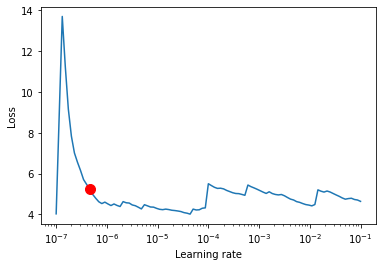

In [33]:
# Use Lightning for suggesting a suitable learning rate

# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=0.1,
    min_lr=1e-7,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [35]:
# Callbacks, Trainer and final Model

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-7, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=4.57e-7,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1,
    loss=pytorch_forecasting.metrics.RMSE(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 19.4k


In [36]:
# fit network

trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)



Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [37]:
# Loade the best model from Lightning checkpoint

# load the best model according to the validation loss
# (given that we use stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [39]:
# Get the validation RMSE

# calculate root mean squared error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_predictions = best_tft.predict(val_dataloader)

In [40]:
torch.cat([y[0] for x, y in iter(val_dataloader)])

tensor([[31.],
        [11.],
        [10.],
        ...,
        [ 1.],
        [ 1.],
        [ 1.]])

In [41]:
criterion = nn.MSELoss()
torch.sqrt(criterion(actuals,val_predictions))

tensor(14.6880)

In [42]:
df_test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
df_test=df_test.drop(['ID'],axis=1)
df_test['date_block_num']=34
df_test['item_cnt_month']=0
# decoder_data=df_test
# encoder_data = df_train[lambda x: x.date_block_num > x.date_block_num.max() - max_encoder_length]
# new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
pred,x=best_tft.predict(df_test,return_x=True)